# Alaiz NSC benchmark

## Introduction
This script summarizes the overall results of the [Alaiz NSC benchmark](https://thewindvaneblog.com/numerical-site-calibration-benchmark-the-alaiz-case-b3767918d812).

## Load libraries

In [1]:
import pandas as pd
import xarray as xr
import numpy as np
#import netCDF4 as nc
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [3]:
def readExcelToDf(simID):
    # load raw results into pandas
    
    import os
    directory = './outputs/'+simID
    mastName = []
    for filename in os.listdir(directory):
        if filename.endswith(".xlsx") and simID in filename:
            filename = filename.replace(simID+'_', '').replace('.xlsx', '')
            mastName.append(filename)

    list_df = []
    # loop on masts
    for k in mastName:

        stab = ['u', 'n', 's']
        filename = './outputs/'+simID+'/'+simID+'_'+k+'.xlsx'
        # loop on stabilities
        for j in range(3):
            
            sheets = ['wind_speed', 'turbulence_intensity']
            variables = dict.fromkeys(sheets)
            for sheet in sheets:
                # read wind speed / turbulence
                try:
                    df_excel = pd.read_excel(open(filename, 'rb'), sheet_name=sheet, usecols="A:K", nrows=6, skiprows=j*8, index_col=None, header=None)
                except:
                    print('Error reading excel:', filename, sheet)
                    return
                heights = list(df_excel.iloc[1:,0])
                sectors = list(df_excel.iloc[0,1:])

                list_df_sheet = []
                # loop on sectors
                for i in range(0, len(sectors)):
                    df_tmp = df_excel.iloc[1:,:].copy()
                    df_tmp['ID'] = simID
                    df_tmp['mast'] = k
                    #df_tmp['mast'] = re.sub('(A.)_SC.', r'\1', k)
                    try:
                        df_tmp['Sector'] = round(sectors[i])
                    except ValueError:
                        print('Error reading excel:', filename, sheet)
                        return
                    df_tmp['Stability'] = stab[j]
                    df_tmp = df_tmp.rename(columns={0:"z", i+1: sheet})[['ID', 'mast', "Sector", "Stability", "z", sheet]]                           
                    list_df_sheet.append(df_tmp)

                variables[sheet] = pd.concat([a for a in list_df_sheet], axis=0)
                variables[sheet].set_index(['ID', 'mast', 'Sector', 'Stability', 'z'], inplace=True)

            try:
                df_sim = pd.concat([variables[sheet] for sheet in sheets], axis=1)
            except:
                print('Error merging dataframes.')
                return
            list_df.append(df_sim)
    
    return list_df

## Results

### Participants

In [4]:
# Read file with simulation descriptions
sims = pd.read_csv('outputs/alaizNSC_sims.csv', na_filter=False)
sims = sims[sims.Remarks!='test']
n_sim = len(sims)
sims

,ID,Participant,Software Name,Model Name,Number of sectors simulated,Stability modelling,Input,"dx, dy [m]",dz [m],L [km],Use time series to transfer wind speed from MP5,Remarks,Label
0,wt168,Huaneng Clean Energy Technology Research Insti...,WT,RANS k-l,,Yes,Default,,,,,Preliminary,
1,wt324,"SPIC Energy Technology & Engineering Co., Ltd",WT+Mesoscale,RANS k-l,"Ten 10° sectors: 340, …, 20° and 150, …, 200°","Yes (class 1, 2, 6)",Default,,,11,,Preliminary,
2,wt110,CGN New Energy,WT,RANS k-l,,"Yes (class 1, 2, 6)",SRTM90m,30,6,12,Yes,Preliminary,
3,wt363,CGN New Energy,WT,RANS k-l,,"Yes (class 1, 2, 6)",Default,30,6,12,Yes,Preliminary,
4,rans233,N/A,N/A,RANS,,,Default,,,,,Preliminary,
5,wt194,"Guohua Energy Investment Co.,Ltd",WT,RANS k-l,,Yes,Default,,,,,Preliminary,
6,wasp949,EDF Renouvelables,Wasp,Linear,,No,Default,,,,Yes,Preliminary,
7,wt949,EDF Renouvelables,WT,RANS k-l,,Yes,Default,,,,Yes,Preliminary,
8,les122,N/A,N/A,LES,,Yes,Default,40,20,,Yes?,Preliminary,
9,rans211,N/A,N/A,RANS,,,Default,,,,,Preliminary,


### Load results

In [5]:
list_df = []

simIDs = sims.ID.values

for simID in simIDs:
    list_df += readExcelToDf(simID)

# concatenate all dataframes.
df_sims = pd.concat([a for a in list_df], axis=0)

### Test with xarray Dataset

In [6]:
# convert to xarray dataset.
ds_sims = xr.Dataset.from_dataframe(df_sims)

In [7]:
# choose subset of simulations
for simID in simIDs:
    if 'MP5_SC2' in df_sims.loc[simID].index.unique('mast'):
        ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5')] = ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC2')]

# define simulation type
simtype = []
for simID in ds_sims.ID.values:
    simtype.append('rans' if ('wt' in simID or 'rans' in simID or 'meteodyn' in simID) else 'les' if 'les' in simID else 'linear' if 'wasp' in simID else '')
ds_sims.coords["simtype"] = ("ID", simtype)

### Flow correction factor (FCF)

In [8]:
ds_sims["flow_correction_factor"] = ds_sims["wind_speed"].copy()
for simID in ds_sims.ID.values:
    if 'MP5_SC1' in df_sims.loc[simID].index.unique('mast') and 'MP5_SC2' in df_sims.loc[simID].index.unique('mast'):
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A1', 'A2', 'A3', 'MP5_SC2'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC2', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast=['A4', 'A5', 'A6', 'MP5_SC1'])] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC1', z=118)]
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5_SC2', z=118)]
    elif simID in ['wt110', 'wt363']:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID, mast='MP5')] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]
    else:
        ds_sims["flow_correction_factor"].loc[dict(ID=simID)] /= ds_sims["wind_speed"].loc[dict(ID=simID, mast='MP5', z=118)]

### Load observation data

In [9]:
ds_all = ds_sims.copy()
ds_all["Sector"] = ds_sims.Sector.astype(str)

fnList = ['./results/'+a for a in ['A1_SC2.nc', 'A2_SC2.nc', 'A3_SC2.nc', 'A4_SC1.nc', 'A5_SC1.nc', 'A6_SC1.nc']] + ['./inputs/'+a for a in ['MP5_SC2.nc']]
obs = dict.fromkeys([fn[0:2] for fn in fnList])
for fn in fnList:
    mast = fn.split('/')[2].split('_')[0]
    obs[mast] = xr.open_dataset(fn)
    obs[mast] = obs[mast].assign_coords(ID='obs')
    obs[mast] = obs[mast].expand_dims('ID')
    obs[mast].coords["simtype"] = ("ID", ['obs'])
    obs[mast] = obs[mast].assign_coords(mast=mast)
    obs[mast] = obs[mast].expand_dims('mast')
    ds_all = xr.merge([ds_all, obs[mast]])

northSectors = ['1', '2', '3', '35', '36']
southSectors = ['16', '17', '18', '19', '20']
norsSectors = northSectors + southSectors
nors = []
for sec in ds_all.coords["Sector"]:
    nors.append('North' if sec in northSectors else 'South' if sec in southSectors else '')
ds_all.coords["nors"] = ("Sector", nors)

# standardize format after merge
ds_all["Sector"] = ds_all.Sector.astype(int)
ds_all = ds_all.sortby(ds_all.Sector, ascending=True)
ds_all["Sector"] = ds_all.Sector.astype(str)

ds_all['samples'] = ds_all.sel(ID='obs')['samples']

## Error calculation

In [10]:
ds_all['error'] = abs(ds_all['flow_correction_factor'] - ds_all['flow_correction_factor'].sel(ID='obs'))/ds_all['flow_correction_factor'].sel(ID='obs')
ds_error = ds_all.sel(Sector=norsSectors, mast=['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5'])

# weighted mean error
#ds_error['errorw'] = ds_error['error']*ds_error['samples']
#ds_error['errorw'] = ds_error['errorw'].sum(dim='Sector') / ds_error['samples'].sum(dim='Sector')

### Back to pandas Dateframe for plotting

In [11]:
df_error = ds_error.sel(z=118)[['error', 'samples']].to_dataframe()
df_error = df_error.drop(columns=['z'])
df_error = df_error.reset_index()
df_error = df_error[df_error.ID != 'obs']
df_error = df_error[df_error.error.notna()]

df_error = df_error.replace({'Stability': 'u'}, 'Unstable')
df_error = df_error.replace({'Stability': 'n'}, 'Neutral')
df_error = df_error.replace({'Stability': 's'}, 'Stable')

# focus on A1-A6 masts
df_error = df_error[df_error.mast.isin(['A1', 'A2', 'A3', 'A4', 'A5', 'A6'])]
df_error.mast.value_counts()

A2    420
A1    420
A3    420
A5    418
A6    417
A4    417
Name: mast, dtype: int64

In [12]:
# weighted mean error
gp = df_error.groupby(['ID', 'Stability', 'mast'])
df_error['error_wt'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_wt'] = gp.error_wt.transform('sum')

gp = df_error.groupby(['ID', 'Stability', 'nors', 'mast'])
df_error['error_ns_wt'] = df_error.error * df_error.samples / gp.samples.transform('sum')
df_error['error_ns_wt'] = gp.error_ns_wt.transform('sum')

### Plot

In [13]:
# define sort order
custom_dict = {'linear': 0, 'rans': 1, 'les': 3, 'obs' : 4, 'u':0,'n':1,'s':2, 'Unstable':0,'Neutral':1,'Stable':2, '1':1, '2':2, '3':3, '35':35, '36':36, '16':16, '17':17, '18':18, '19':19, '20':20}

          ID     error  error_wt
0   rans135c  0.055831  0.051241
1      wt949  0.054905  0.053603
2   rans135a  0.062452  0.054773
3   rans135b  0.063143  0.055696
4    wasp949  0.056420  0.056647
5      wt110  0.058849  0.058085
6      wt363  0.059316  0.058547
7    rans270  0.060756  0.059558
8      wt168  0.062624  0.060834
9    rans211  0.060102  0.064251
10     wt194  0.072976  0.064572
11   rans233  0.071453  0.066522
12     wt324  0.068823  0.069505
13    les122  0.103054  0.094638


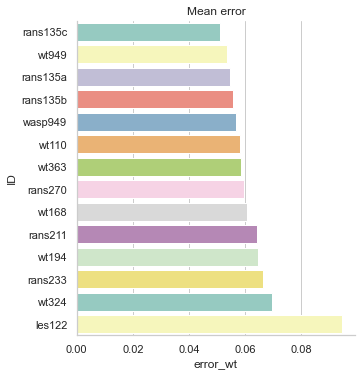

In [14]:
df_plot = df_error.groupby(['ID']).mean().sort_values(by=['error_wt']).reset_index()[['ID', 'error', 'error_wt']]
print(df_plot)

sns.set(style="whitegrid")
g = sns.catplot(x="error_wt", y="ID", kind="bar", data=df_plot, palette='Set3')
plt.title("Mean error")
saved_sort_order = dict((v,k) for k,v in df_plot.ID.to_dict().items())

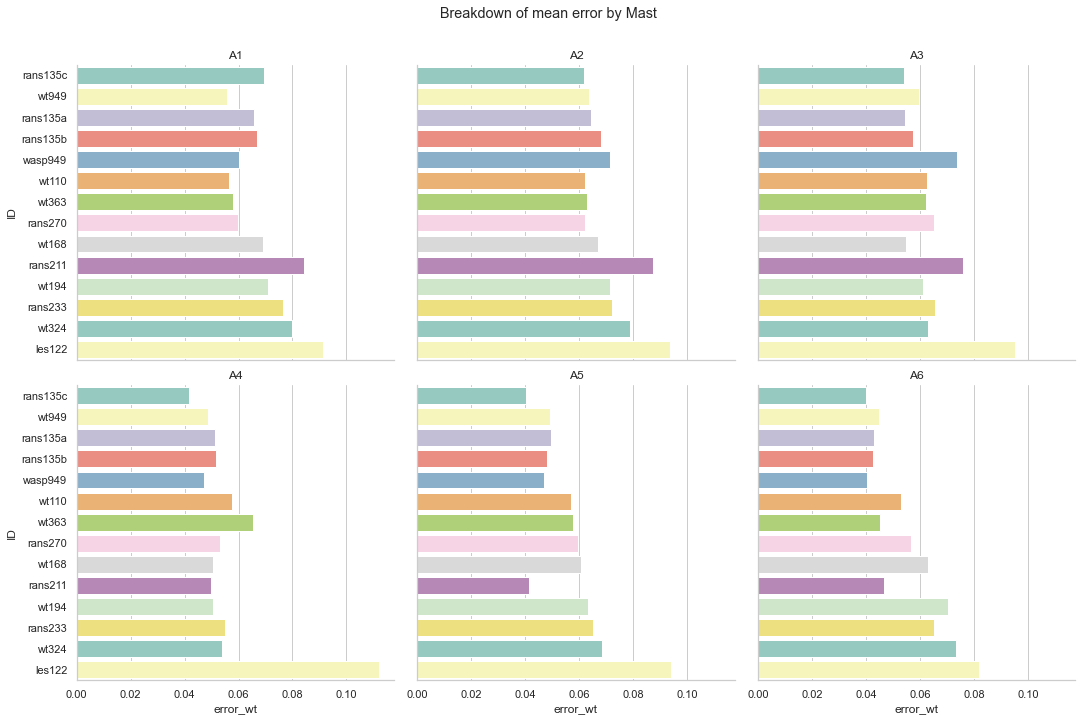

In [15]:
df_plot = df_error.groupby(['ID', 'mast']).mean().reset_index()
df_plot.sort_values(by=['mast', 'ID'], key=lambda x: x.map(saved_sort_order), inplace=True)

g = sns.catplot(x="error_wt", y="ID", col='mast', col_wrap=3, kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean error by Mast")
g.fig.subplots_adjust(top=.9)
g.set_titles('{col_name}')

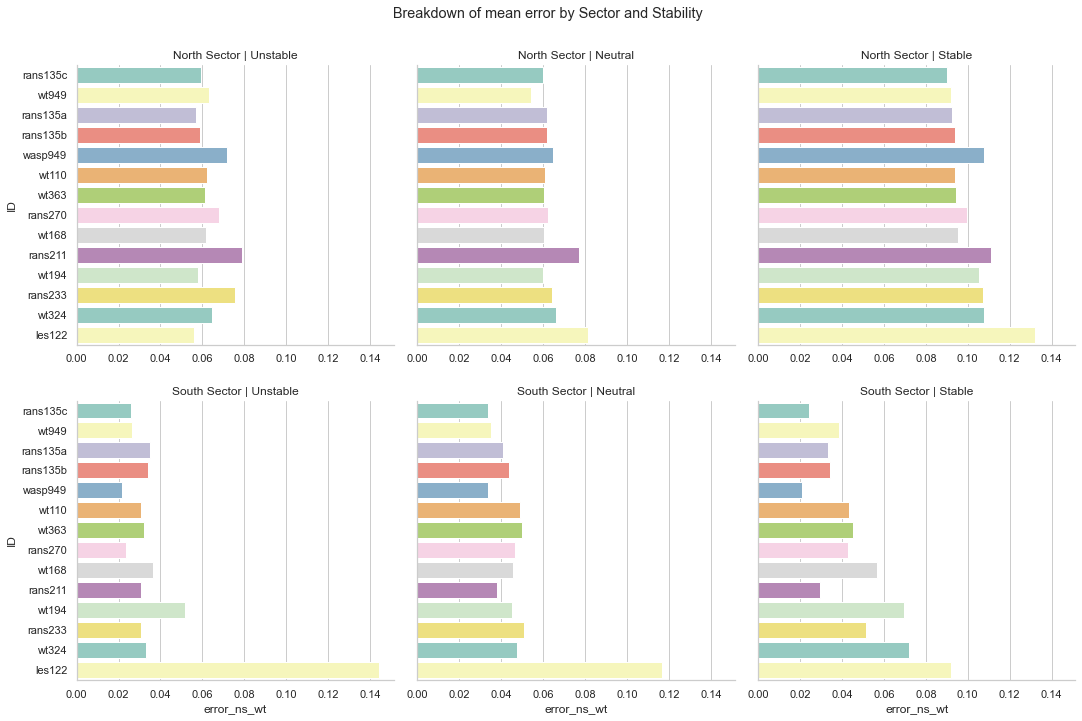

In [16]:
custom_dict.update(saved_sort_order)

df_plot = df_error.groupby(['nors', 'Stability', 'ID']).mean().reset_index()
df_plot.sort_values(by=['nors', 'Stability', 'ID'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="error_ns_wt", y="ID", col='Stability', row='nors', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean error by Sector and Stability")
g.fig.subplots_adjust(top=.9)
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

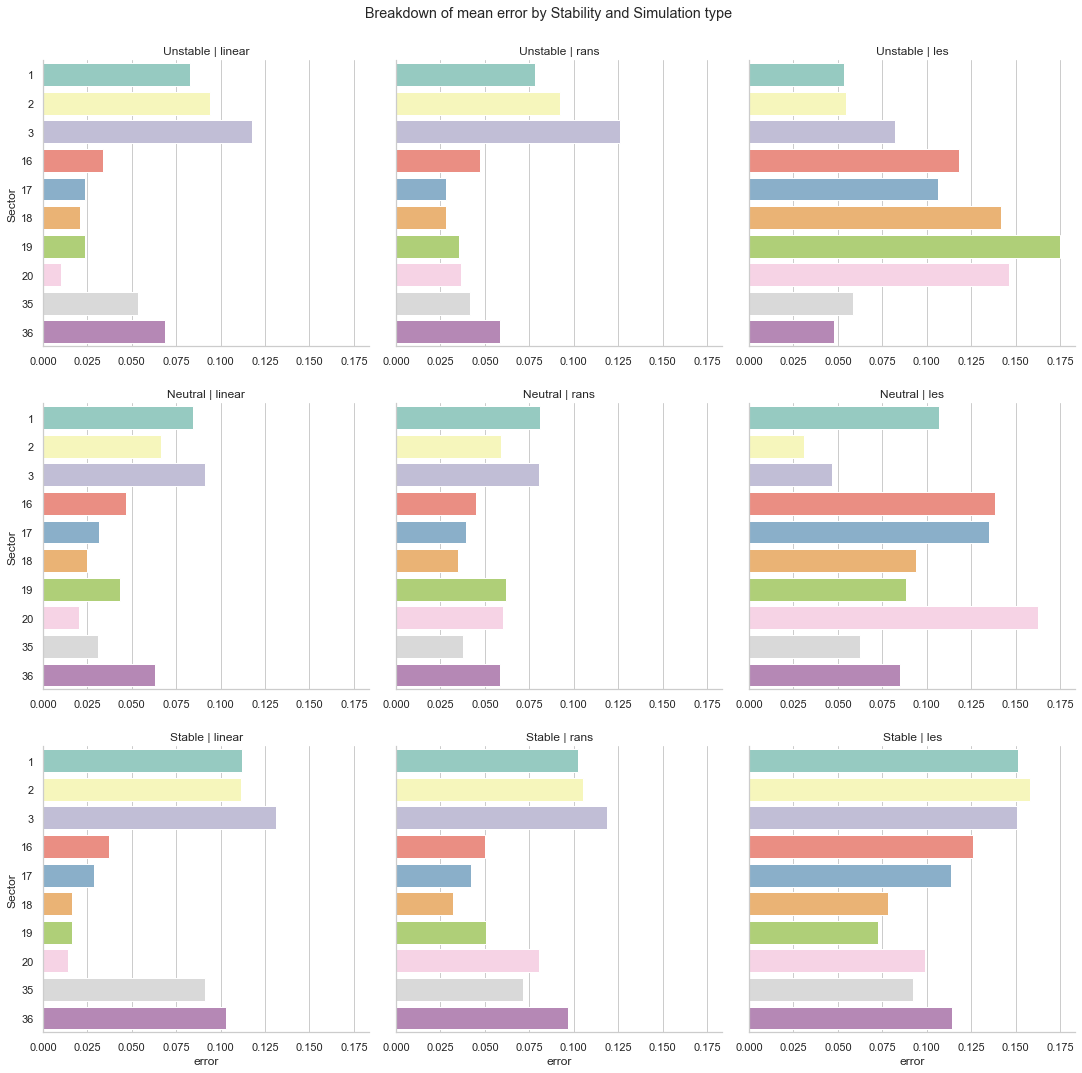

In [17]:
df_plot = df_error.groupby(['simtype', 'Sector', 'Stability']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Sector', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.catplot(x="error", y="Sector", col='simtype', row='Stability', kind="bar", data=df_plot, palette='Set3')
g.fig.suptitle("Breakdown of mean error by Stability and Simulation type")
g.fig.subplots_adjust(top=.93)
g.set_titles('{row_name}' ' | ' '{col_name}')
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)

## FCF profiles

In [18]:
df_fcf = ds_all['flow_correction_factor'].to_dataframe()
df_fcf = df_fcf.reset_index()
df_fcf = df_fcf[df_fcf['nors']!='']
df_fcf = df_fcf[df_fcf.mast.isin(['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'MP5'])]
df_fcf = df_fcf[df_fcf['flow_correction_factor'].notna()]

df_fcf = df_fcf.replace({'Stability': 'u'}, 'Unstable')
df_fcf = df_fcf.replace({'Stability': 'n'}, 'Neutral')
df_fcf = df_fcf.replace({'Stability': 's'}, 'Stable')

df_fcf.mast.value_counts()

A2     2247
A4     2238
A3     2217
A1     2217
A5     2210
A6     2208
MP5    2130
Name: mast, dtype: int64

### Plot

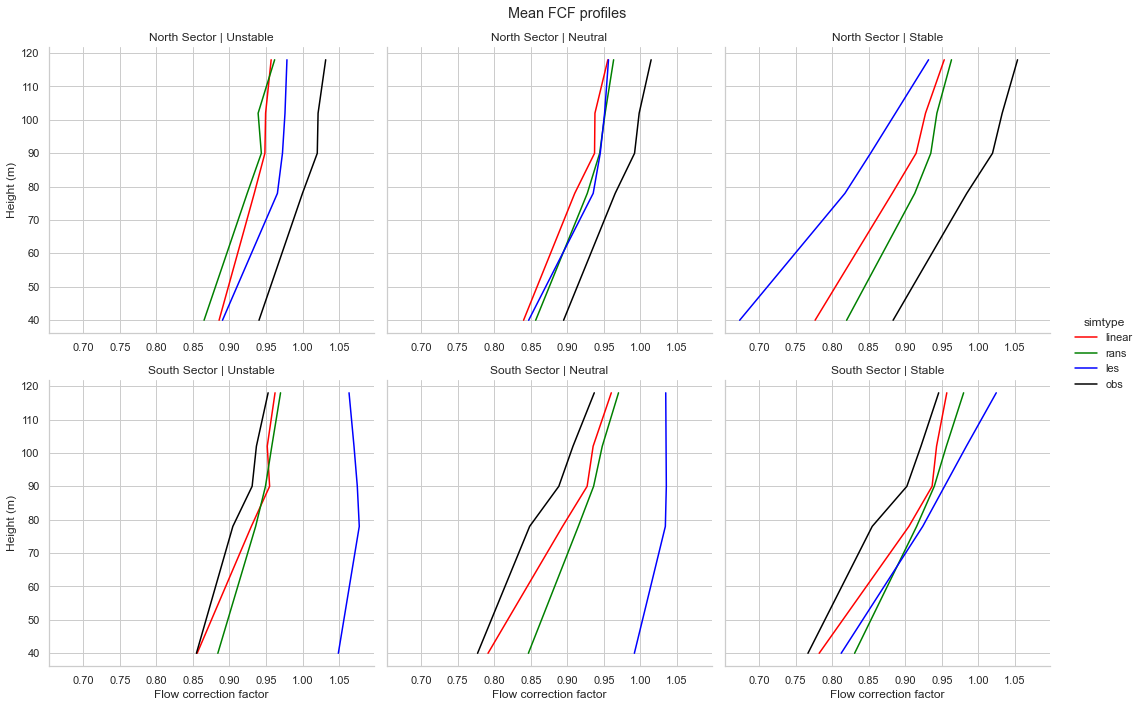

In [19]:
sns.set_theme(style="whitegrid")

# Create an array with the colors you want to use
colors = ['red', 'green', 'blue', 'black']
# Set your custom color palette
customPalette = sns.set_palette(sns.color_palette(colors))

df_plot = df_fcf.groupby(['simtype', 'z', 'Stability', 'nors']).mean().reset_index()
df_plot.sort_values(by=['simtype', 'Stability'], key=lambda x: x.map(custom_dict), inplace=True)

g = sns.relplot(data=df_plot, x="flow_correction_factor", y="z", sort=False, col='Stability', row='nors', hue='simtype', kind='line', palette = customPalette)

g.set_axis_labels("Flow correction factor", "Height (m)")
g.set_titles('{row_name} Sector' ' | ' '{col_name}')
g.fig.suptitle("Mean FCF profiles")
g.fig.subplots_adjust(top=.9)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.subplots_adjust(hspace = 0.2)
g.tight_layout()
#g.savefig("facet_plot.png")